In [3]:
# ============================================================================
# 03_MULTICLASS_TRAINING.IPYNB
# ============================================================================
# PURPOSE: Train single 3-way classifier (SAFE, SENSITIVE, UNSAFE)
# MODEL: RoBERTa-base with Focal Loss for class imbalance
# TARGET: High UNSAFE recall + good overall accuracy
# TIME ESTIMATE: 1 hour with 1x B200 GPU
# ============================================================================

In [4]:
import torch

# Single Multi-Class Classifier

## Objective
Train ONE model to classify articles into 3 categories: SAFE, SENSITIVE, UNSAFE

## Strategy
- Model: RoBERTa-base (125M parameters)
- Loss: Multi-class Focal Loss (handles imbalance)
- Class weights: Boost UNSAFE class (18% of data)
- Target: 85%+ UNSAFE recall, 75%+ overall accuracy

## 1. Setup and Imports

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_fscore_support
)
import warnings
warnings.filterwarnings('ignore')

notebook_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_dir, '..'))

# PyTorch and Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AdamW, get_linear_schedule_with_warmup
)

from tqdm.auto import tqdm

#Set random seeds
RANDOM_SEED = 3004085269 #3914328271
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("Seed: ", torch.initial_seed())

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create results directory
os.makedirs(os.path.join(PROJECT_ROOT, 'results', 'multiclass_classifier'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_ROOT, 'models', 'multiclass_classifier'), exist_ok=True)

print("\n✓ Setup complete")

Seed:  3004085269
Using device: cuda
GPU: NVIDIA B200
GPU Memory: 191.51 GB

✓ Setup complete


## 2. Configuration

In [8]:
CONFIG = {
    'model_name': 'roberta-base',
    'max_length': 512,
    'batch_size': 16,
    'learning_rate': 1e-5,
    'epochs': 5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.1,           # Stronger regularization
    'focal_loss_gamma': 3,         # Focus on hard examples
    'focal_loss_alpha': [1.0,  3.0, 5.0],  # Class weights: [SAFE, SENSITIVE, UNSAFE]
    'max_grad_norm': 1.0,
    'early_stopping_patience': 2,
    'use_mixed_precision': True,   # Use FP16 for faster training
    'label_smoothing': 0.05,       # Label smoothing for generalization
    'hidden_dropout': 0.2,         # Dropout in hidden layers
    'attention_dropout': 0.1,      # Dropout in attention layers
    'save_safe_tensors': True      # Use SafeTensors format when saving
}

print("Multi-Class Configuration:")
print(json.dumps(CONFIG, indent=2))
safe_weight, sensitive_weight, unsafe_weight = CONFIG['focal_loss_alpha']

print(f"→ Class weights: SAFE={safe_weight}, SENSITIVE={sensitive_weight}, UNSAFE={unsafe_weight}\n→ UNSAFE errors are {unsafe_weight/safe_weight}x more costly than SAFE errors")

if CONFIG.get('use_mixed_precision', False):
    print('→ Mixed precision training: Enabled (FP16)')

if CONFIG.get('label_smoothing', 0) > 0:
    print(f'→ Label smoothing: {CONFIG["label_smoothing"]:.1%}')

print(f'→ SafeTensors saving: {"Enabled" if CONFIG.get("save_safe_tensors", True) else "Disabled"}')


Multi-Class Configuration:
{
  "model_name": "roberta-base",
  "max_length": 512,
  "batch_size": 16,
  "learning_rate": 1e-05,
  "epochs": 5,
  "warmup_ratio": 0.1,
  "weight_decay": 0.1,
  "focal_loss_gamma": 3,
  "focal_loss_alpha": [
    1.0,
    3.0,
    5.0
  ],
  "max_grad_norm": 1.0,
  "early_stopping_patience": 2,
  "use_mixed_precision": true,
  "label_smoothing": 0.05,
  "hidden_dropout": 0.2,
  "attention_dropout": 0.1,
  "save_safe_tensors": true
}
→ Class weights: SAFE=1.0, SENSITIVE=3.0, UNSAFE=5.0
→ UNSAFE errors are 5.0x more costly than SAFE errors
→ Mixed precision training: Enabled (FP16)
→ Label smoothing: 5.0%
→ SafeTensors saving: Enabled


## 3. Load Datasets

In [9]:
print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

# Load full datasets (all 3 classes)
train_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_stage2_input.csv'))
val_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'val_stage2_input.csv'))
test_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_stage2_input.csv'))

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print("\nTrain label distribution:d")
label_counts = train_df['label'].value_counts()
print(label_counts)
print(f"\nPercentages:")
for label, count in label_counts.items():
    print(f"  {label:12s}: {count/len(train_df)*100:5.1f}%")

print("\nVal label distribution:")
print(val_df['label'].value_counts())

# Check class imbalance
unsafe_ratio = (train_df['label'] == 'UNSAFE').sum() / len(train_df)
if unsafe_ratio < 0.20:
    print(f"\n⚠️ WARNING: UNSAFE class is minority ({unsafe_ratio*100:.1f}%)")
    print("   → Using Focal Loss with high alpha for UNSAFE")


LOADING DATASETS
Train: 4947 samples
Val: 1060 samples
Test: 1061 samples

Train label distribution:d
label
SENSITIVE    2129
SAFE         1928
UNSAFE        890
Name: count, dtype: int64

Percentages:
  SENSITIVE   :  43.0%
  SAFE        :  39.0%
  UNSAFE      :  18.0%

Val label distribution:
label
SENSITIVE    456
SAFE         412
UNSAFE       192
Name: count, dtype: int64

⚠️ WARNING: UNSAFE class is minority (18.0%)
   → Using Focal Loss with high alpha for UNSAFE


## 4. Create Label Encodings

In [10]:
# Create label encoding for 3-way classification
label2id = {'SAFE': 0, 'SENSITIVE': 1, 'UNSAFE': 2}
id2label = {0: 'SAFE', 1: 'SENSITIVE', 2: 'UNSAFE'}

print("Label encoding:")
for label, idx in label2id.items():
    print(f"  {label:12s} → {idx}")

# Add encoded labels
train_df['label_id'] = train_df['label'].map(label2id)
val_df['label_id'] = val_df['label'].map(label2id)
test_df['label_id'] = test_df['label'].map(label2id)

# Verify
assert train_df['label_id'].isnull().sum() == 0, "ERROR: Label encoding failed!"
print("\n✓ Labels encoded successfully")

Label encoding:
  SAFE         → 0
  SENSITIVE    → 1
  UNSAFE       → 2

✓ Labels encoded successfully


## 5. Initialize Tokenizer

In [11]:
print("\n" + "="*80)
print("INITIALIZING TOKENIZER")
print("="*80)

tokenizer = RobertaTokenizer.from_pretrained(CONFIG['model_name'])

print(f"Tokenizer: {CONFIG['model_name']}")
print(f"Vocab size: {len(tokenizer)}")
print(f"Max length: {CONFIG['max_length']}")

print("\n✓ Tokenizer ready")


INITIALIZING TOKENIZER
Tokenizer: roberta-base
Vocab size: 50265
Max length: 512

✓ Tokenizer ready


## 6. Create PyTorch Dataset

In [12]:
class NewsDataset(Dataset):
    """
    PyTorch Dataset for 3-way classification.
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = NewsDataset(
    texts=train_df['text'].values,
    labels=train_df['label_id'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

val_dataset = NewsDataset(
    texts=val_df['text'].values,
    labels=val_df['label_id'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length']
)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

print("\n✓ Datasets created")


Train dataset: 4947 samples
Val dataset: 1060 samples

✓ Datasets created


## 7. Create DataLoaders

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Calculate training steps
total_steps = len(train_loader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

print(f"\nTraining schedule:")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")

print("\n✓ DataLoaders ready")

Train batches per epoch: 310
Val batches: 67

Training schedule:
  Total steps: 1550
  Warmup steps: 155

✓ DataLoaders ready


## 8. Define Multi-Class Focal Loss

In [16]:
class MultiClassFocalLoss(nn.Module):
    """
    Focal Loss for multi-class classification with class imbalance.
    
    Args:
        alpha: List of class weights [weight_class0, weight_class1, weight_class2]
        gamma: Focusing parameter (higher = more focus on hard examples)
    """
    def __init__(self, alpha=None, gamma=2, reduction='mean', label_smoothing=0.0):
        super(MultiClassFocalLoss, self).__init__()
        if alpha is not None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = None
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Model logits [batch_size, num_classes]
            targets: True labels [batch_size]
        """
        # Calculate cross-entropy loss with optional label smoothing
        if self.label_smoothing > 0:
            num_classes = inputs.size(-1)
            smooth_labels = torch.zeros_like(inputs)
            smooth_labels.fill_(self.label_smoothing / (num_classes - 1))
            smooth_labels.scatter_(1, targets.unsqueeze(1), 1.0 - self.label_smoothing)
            log_probs = F.log_softmax(inputs, dim=-1)
            ce_loss = -(smooth_labels * log_probs).sum(dim=-1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get predicted probabilities
        pt = torch.exp(-ce_loss)
        
        # Calculate focal loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        # Apply class weights if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        # Reduce
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize focal loss
focal_loss_fn = MultiClassFocalLoss(
    alpha=CONFIG['focal_loss_alpha'],  # [SAFE=1.0, SENSITIVE=3.0, UNSAFE=5.0]
    gamma=CONFIG['focal_loss_gamma'],
    reduction='mean',
    label_smoothing=CONFIG.get('label_smoothing', 0)
)

print("\nMulti-Class Focal Loss configured:")
print(f"  Alpha (class weights): {CONFIG['focal_loss_alpha']}")
print(f"    SAFE: {CONFIG['focal_loss_alpha'][0]}")
print(f"    SENSITIVE: {CONFIG['focal_loss_alpha'][1]}")
print(f"    UNSAFE: {CONFIG['focal_loss_alpha'][2]}")
print(f"  Gamma (focusing): {CONFIG['focal_loss_gamma']}")
print("\n→ UNSAFE errors are 5x more costly than SAFE errors")
print("→ SENSITIVE errors are 3x more costly than SAFE errors")
if CONFIG.get('label_smoothing', 0) > 0:
    print(f"→ Label smoothing: {CONFIG['label_smoothing']:.1%} (improves generalization)")

print("\n✓ Focal Loss ready")


Multi-Class Focal Loss configured:
  Alpha (class weights): [1.0, 3.0, 5.0]
    SAFE: 1.0
    SENSITIVE: 3.0
    UNSAFE: 5.0
  Gamma (focusing): 3

→ UNSAFE errors are 5x more costly than SAFE errors
→ SENSITIVE errors are 3x more costly than SAFE errors
→ Label smoothing: 5.0% (improves generalization)

✓ Focal Loss ready


## 9. Initialize Model

In [17]:
print("\n" + "="*80)
print("INITIALIZING MODEL")
print("="*80)

# Load RoBERTa for 3-way classification
model = RobertaForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=3,  # 3-way classification: SAFE, SENSITIVE, UNSAFE
    hidden_dropout_prob=CONFIG.get('hidden_dropout', 0.2),
    attention_probs_dropout_prob=CONFIG.get('attention_dropout', 0.1),
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {CONFIG['model_name']}")
print(f"Number of classes: 3 (SAFE, SENSITIVE, UNSAFE)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\n✓ Model initialized")


INITIALIZING MODEL


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: roberta-base
Number of classes: 3 (SAFE, SENSITIVE, UNSAFE)
Total parameters: 124,647,939
Trainable parameters: 124,647,939

✓ Model initialized


## 10. Setup Optimizer and Scheduler

In [18]:
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    eps=1e-8
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Optimizer: AdamW")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")

print(f"\nScheduler: Linear warmup + decay")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Total steps: {total_steps}")

print("\n✓ Optimizer and scheduler ready")

Optimizer: AdamW
  Learning rate: 1e-05
  Weight decay: 0.1

Scheduler: Linear warmup + decay
  Warmup steps: 155
  Total steps: 1550

✓ Optimizer and scheduler ready


## 11. Training and Evaluation Functions

In [19]:
def train_epoch(model, data_loader, optimizer, scheduler, device, focal_loss_fn):
    """Train model for one epoch with optional mixed precision training."""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    # Initialize mixed precision scaler if enabled
    use_amp = CONFIG.get('use_mixed_precision', False) and torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with mixed precision if enabled
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                logits = outputs.logits
                loss = focal_loss_fn(logits, labels)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            loss = focal_loss_fn(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
            optimizer.step()
        
        scheduler.step()
        
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        total_loss += loss.item()
        
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct_predictions / total_predictions
        })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy


def evaluate(model, data_loader, device, focal_loss_fn):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            
            loss = focal_loss_fn(logits, labels)
            total_loss += loss.item()
            
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    
    metrics = {
        'SAFE': {
            'precision': precision[0],
            'recall': recall[0],
            'f1': f1[0],
            'support': support[0]
        },
        'SENSITIVE': {
            'precision': precision[1],
            'recall': recall[1],
            'f1': f1[1],
            'support': support[1]
        },
        'UNSAFE': {
            'precision': precision[2],
            'recall': recall[2],
            'f1': f1[2],
            'support': support[2]
        }
    }
    
    return avg_loss, accuracy, metrics, all_preds, all_labels, all_probs

print("\n✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


## 12. Training Loop

In [20]:
print("\n" + "="*80)
print("STARTING MULTI-CLASS TRAINING")
print("="*80)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_safe_recall': [],
    'val_sensitive_recall': [],
    'val_unsafe_recall': [],
    'val_unsafe_precision': [],
    'val_unsafe_f1': [],
    'combined_score': []  # ← Add this
}

best_score = 0
epochs_without_improvement = 0

print(f"\nTraining for {CONFIG['epochs']} epochs...")
print(f"Primary target: UNSAFE recall ≥ 85%")
print(f"Secondary target: Overall accuracy ≥ 75%")
print(f"Early stopping patience: {CONFIG['early_stopping_patience']} epochs")
print("\n" + "="*80 + "\n")

for epoch in range(CONFIG['epochs']):
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device, focal_loss_fn
    )
    
    # Evaluate
    val_loss, val_acc, val_metrics, val_preds, val_labels, val_probs = evaluate(
        model, val_loader, device, focal_loss_fn
    )
    
    # Extract metrics
    unsafe_recall = val_metrics['UNSAFE']['recall']
    unsafe_precision = val_metrics['UNSAFE']['precision']
    unsafe_f1 = val_metrics['UNSAFE']['f1']
    
     # Weighted score: UNSAFE recall (primary) + SENSITIVE recall (secondary) + accuracy
    sensitive_recall = val_metrics['SENSITIVE']['recall']
    safe_recall = val_metrics['SAFE']['recall']  # ← Add this
    
    # Calculate combined score with explicit SAFE
    combined_score = (unsafe_recall * 0.5 +      # UNSAFE: most critical
                      sensitive_recall * 0.3 +    # SENSITIVE: avoid unfiltered content
                      safe_recall * 0.15 +        # SAFE: avoid unnecessary reframing
                      val_acc * 0.05)             # Overall: sanity check
    
     # Add this to your training loop
    UNSAFE_MIN_THRESHOLD = 0.84

    if unsafe_recall < UNSAFE_MIN_THRESHOLD:
        # Force UNSAFE improvement
        combined_score = unsafe_recall * 0.90 + val_acc * 0.10

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_safe_recall'].append(val_metrics['SAFE']['recall'])
    history['val_sensitive_recall'].append(val_metrics['SENSITIVE']['recall'])
    history['val_unsafe_recall'].append(unsafe_recall)
    history['val_unsafe_precision'].append(unsafe_precision)
    history['val_unsafe_f1'].append(unsafe_f1)
    history['combined_score'].append(combined_score)

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ({'✓' if val_acc >= 0.75 else '✗'} target: ≥0.75)")
    
    print(f"\nSAFE Metrics:")
    print(f"  Precision: {val_metrics['SAFE']['precision']:.4f}")
    print(f"  Recall: {val_metrics['SAFE']['recall']:.4f}")
    print(f"  F1: {val_metrics['SAFE']['f1']:.4f}")
    print(f"  Support: {val_metrics['SAFE']['support']}")
    
    print(f"\nSENSITIVE Metrics (SECONDARY TARGET):")
    print(f"  Precision: {val_metrics['SENSITIVE']['precision']:.4f}")
    print(f"  Recall: {val_metrics['SENSITIVE']['recall']:.4f}")
    print(f"  F1: {val_metrics['SENSITIVE']['f1']:.4f}")
    print(f"  Support: {val_metrics['SENSITIVE']['support']}")
    
    print(f"\nUNSAFE Metrics (PRIMARY TARGET):")
    print(f"  Precision: {unsafe_precision:.4f}")
    print(f"  Recall: {unsafe_recall:.4f} ({'✓' if unsafe_recall >= 0.80 else '✗'} target: ≥0.80)")
    print(f"  F1: {unsafe_f1:.4f}")
    print(f"  Support: {val_metrics['UNSAFE']['support']}")
    
    print(f"\nCombined Score: {combined_score:.4f}")
    print(f"  Components:")
    print(f"    UNSAFE recall:     {unsafe_recall:.4f} (weight: 0.50) = {unsafe_recall * 0.5:.4f}")
    print(f"    SENSITIVE recall:  {sensitive_recall:.4f} (weight: 0.30) = {sensitive_recall * 0.3:.4f}")
    print(f"    SAFE recall:       {safe_recall:.4f} (weight: 0.15) = {safe_recall * 0.15:.4f}")
    print(f"    Overall accuracy:  {val_acc:.4f} (weight: 0.05) = {val_acc * 0.05:.4f}")
    
    
    if combined_score > best_score:
        best_score = combined_score
        epochs_without_improvement = 0
        
        # Save model
        model.save_pretrained(os.path.join(PROJECT_ROOT, 'models', 'multiclass_classifier', 'best_model'), safe_serialization=CONFIG.get('save_safe_tensors', True))
        tokenizer.save_pretrained(os.path.join(PROJECT_ROOT, 'models', 'multiclass_classifier', 'best_model'))
        
        # Save metrics
        best_metrics = {
            'epoch': epoch + 1,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'safe_recall': val_metrics['SAFE']['recall'],
            'safe_precision': val_metrics['SAFE']['precision'],
            'safe_f1': val_metrics['SAFE']['f1'],
            'sensitive_recall': val_metrics['SENSITIVE']['recall'],
            'sensitive_precision': val_metrics['SENSITIVE']['precision'],
            'sensitive_f1': val_metrics['SENSITIVE']['f1'],
            'unsafe_recall': unsafe_recall,
            'unsafe_precision': unsafe_precision,
            'unsafe_f1': unsafe_f1,
            'combined_score': combined_score,
        }
        with open(os.path.join(PROJECT_ROOT, 'models', 'multiclass_classifier', 'best_metrics.json'), 'w') as f:
            json.dump(best_metrics, f, indent=2)
        
        print(f"\n✓ New best model saved!")
        print(f"  Combined score: {combined_score:.4f}")
        print(f"  UNSAFE recall: {unsafe_recall:.4f}")
        print(f"  SENSITIVE recall: {sensitive_recall:.4f}")
        print(f"  Accuracy: {val_acc:.4f}")
    else:
        epochs_without_improvement += 1
        print(f"\nNo improvement for {epochs_without_improvement} epoch(s)")
    
    # Early stopping
    if epochs_without_improvement >= CONFIG['early_stopping_patience']:
        print(f"\n{'='*80}")
        print(f"EARLY STOPPING: No improvement for {CONFIG['early_stopping_patience']} epochs")
        print(f"{'='*80}")
        break
    
    print("\n" + "="*80 + "\n")

print("\n" + "="*80)
print("MULTI-CLASS TRAINING COMPLETE!")
print("="*80)
print(f"\nBest Combined Weighted Score: {combined_score:.4f}")
print(f"Saved to: models/multiclass_classifier/best_model/")


STARTING MULTI-CLASS TRAINING

Training for 5 epochs...
Primary target: UNSAFE recall ≥ 85%
Secondary target: Overall accuracy ≥ 75%
Early stopping patience: 2 epochs


Epoch 1/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


Train Loss: 0.6156 | Train Acc: 0.5231
Val Loss: 0.3479 | Val Acc: 0.7170 (✗ target: ≥0.75)

SAFE Metrics:
  Precision: 0.8962
  Recall: 0.5655
  F1: 0.6935
  Support: 412

SENSITIVE Metrics (SECONDARY TARGET):
  Precision: 0.6370
  Recall: 0.8311
  F1: 0.7212
  Support: 456

UNSAFE Metrics (PRIMARY TARGET):
  Precision: 0.7220
  Recall: 0.7708 (✗ target: ≥0.80)
  F1: 0.7456
  Support: 192

Combined Score: 0.7654
  Components:
    UNSAFE recall:     0.7708 (weight: 0.50) = 0.3854
    SENSITIVE recall:  0.8311 (weight: 0.30) = 0.2493
    SAFE recall:       0.5655 (weight: 0.15) = 0.0848
    Overall accuracy:  0.7170 (weight: 0.05) = 0.0358

✓ New best model saved!
  Combined score: 0.7654
  UNSAFE recall: 0.7708
  SENSITIVE recall: 0.8311
  Accuracy: 0.7170


Epoch 2/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


Train Loss: 0.3393 | Train Acc: 0.7696
Val Loss: 0.3020 | Val Acc: 0.7868 (✓ target: ≥0.75)

SAFE Metrics:
  Precision: 0.8899
  Recall: 0.7451
  F1: 0.8111
  Support: 412

SENSITIVE Metrics (SECONDARY TARGET):
  Precision: 0.7315
  Recall: 0.8246
  F1: 0.7753
  Support: 456

UNSAFE Metrics (PRIMARY TARGET):
  Precision: 0.7512
  Recall: 0.7865 (✗ target: ≥0.80)
  F1: 0.7684
  Support: 192

Combined Score: 0.7865
  Components:
    UNSAFE recall:     0.7865 (weight: 0.50) = 0.3932
    SENSITIVE recall:  0.8246 (weight: 0.30) = 0.2474
    SAFE recall:       0.7451 (weight: 0.15) = 0.1118
    Overall accuracy:  0.7868 (weight: 0.05) = 0.0393

✓ New best model saved!
  Combined score: 0.7865
  UNSAFE recall: 0.7865
  SENSITIVE recall: 0.8246
  Accuracy: 0.7868


Epoch 3/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


Train Loss: 0.2581 | Train Acc: 0.8187
Val Loss: 0.3293 | Val Acc: 0.8104 (✓ target: ≥0.75)

SAFE Metrics:
  Precision: 0.8827
  Recall: 0.8034
  F1: 0.8412
  Support: 412

SENSITIVE Metrics (SECONDARY TARGET):
  Precision: 0.7590
  Recall: 0.8355
  F1: 0.7954
  Support: 456

UNSAFE Metrics (PRIMARY TARGET):
  Precision: 0.8033
  Recall: 0.7656 (✗ target: ≥0.80)
  F1: 0.7840
  Support: 192

Combined Score: 0.7701
  Components:
    UNSAFE recall:     0.7656 (weight: 0.50) = 0.3828
    SENSITIVE recall:  0.8355 (weight: 0.30) = 0.2507
    SAFE recall:       0.8034 (weight: 0.15) = 0.1205
    Overall accuracy:  0.8104 (weight: 0.05) = 0.0405

No improvement for 1 epoch(s)


Epoch 4/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


Train Loss: 0.2112 | Train Acc: 0.8524
Val Loss: 0.3738 | Val Acc: 0.8151 (✓ target: ≥0.75)

SAFE Metrics:
  Precision: 0.9048
  Recall: 0.7840
  F1: 0.8401
  Support: 412

SENSITIVE Metrics (SECONDARY TARGET):
  Precision: 0.7598
  Recall: 0.8465
  F1: 0.8008
  Support: 456

UNSAFE Metrics (PRIMARY TARGET):
  Precision: 0.7949
  Recall: 0.8073 (✓ target: ≥0.80)
  F1: 0.8010
  Support: 192

Combined Score: 0.8081
  Components:
    UNSAFE recall:     0.8073 (weight: 0.50) = 0.4036
    SENSITIVE recall:  0.8465 (weight: 0.30) = 0.2539
    SAFE recall:       0.7840 (weight: 0.15) = 0.1176
    Overall accuracy:  0.8151 (weight: 0.05) = 0.0408

✓ New best model saved!
  Combined score: 0.8081
  UNSAFE recall: 0.8073
  SENSITIVE recall: 0.8465
  Accuracy: 0.8151


Epoch 5/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


Train Loss: 0.1841 | Train Acc: 0.8765
Val Loss: 0.3990 | Val Acc: 0.8283 (✓ target: ≥0.75)

SAFE Metrics:
  Precision: 0.8874
  Recall: 0.8228
  F1: 0.8539
  Support: 412

SENSITIVE Metrics (SECONDARY TARGET):
  Precision: 0.7853
  Recall: 0.8421
  F1: 0.8127
  Support: 456

UNSAFE Metrics (PRIMARY TARGET):
  Precision: 0.8201
  Recall: 0.8073 (✓ target: ≥0.80)
  F1: 0.8136
  Support: 192

Combined Score: 0.8094
  Components:
    UNSAFE recall:     0.8073 (weight: 0.50) = 0.4036
    SENSITIVE recall:  0.8421 (weight: 0.30) = 0.2526
    SAFE recall:       0.8228 (weight: 0.15) = 0.1234
    Overall accuracy:  0.8283 (weight: 0.05) = 0.0414

✓ New best model saved!
  Combined score: 0.8094
  UNSAFE recall: 0.8073
  SENSITIVE recall: 0.8421
  Accuracy: 0.8283



MULTI-CLASS TRAINING COMPLETE!

Best Combined Weighted Score: 0.8094
Saved to: models/multiclass_classifier/best_model/


## 13. Plot Training History


PLOTTING TRAINING HISTORY


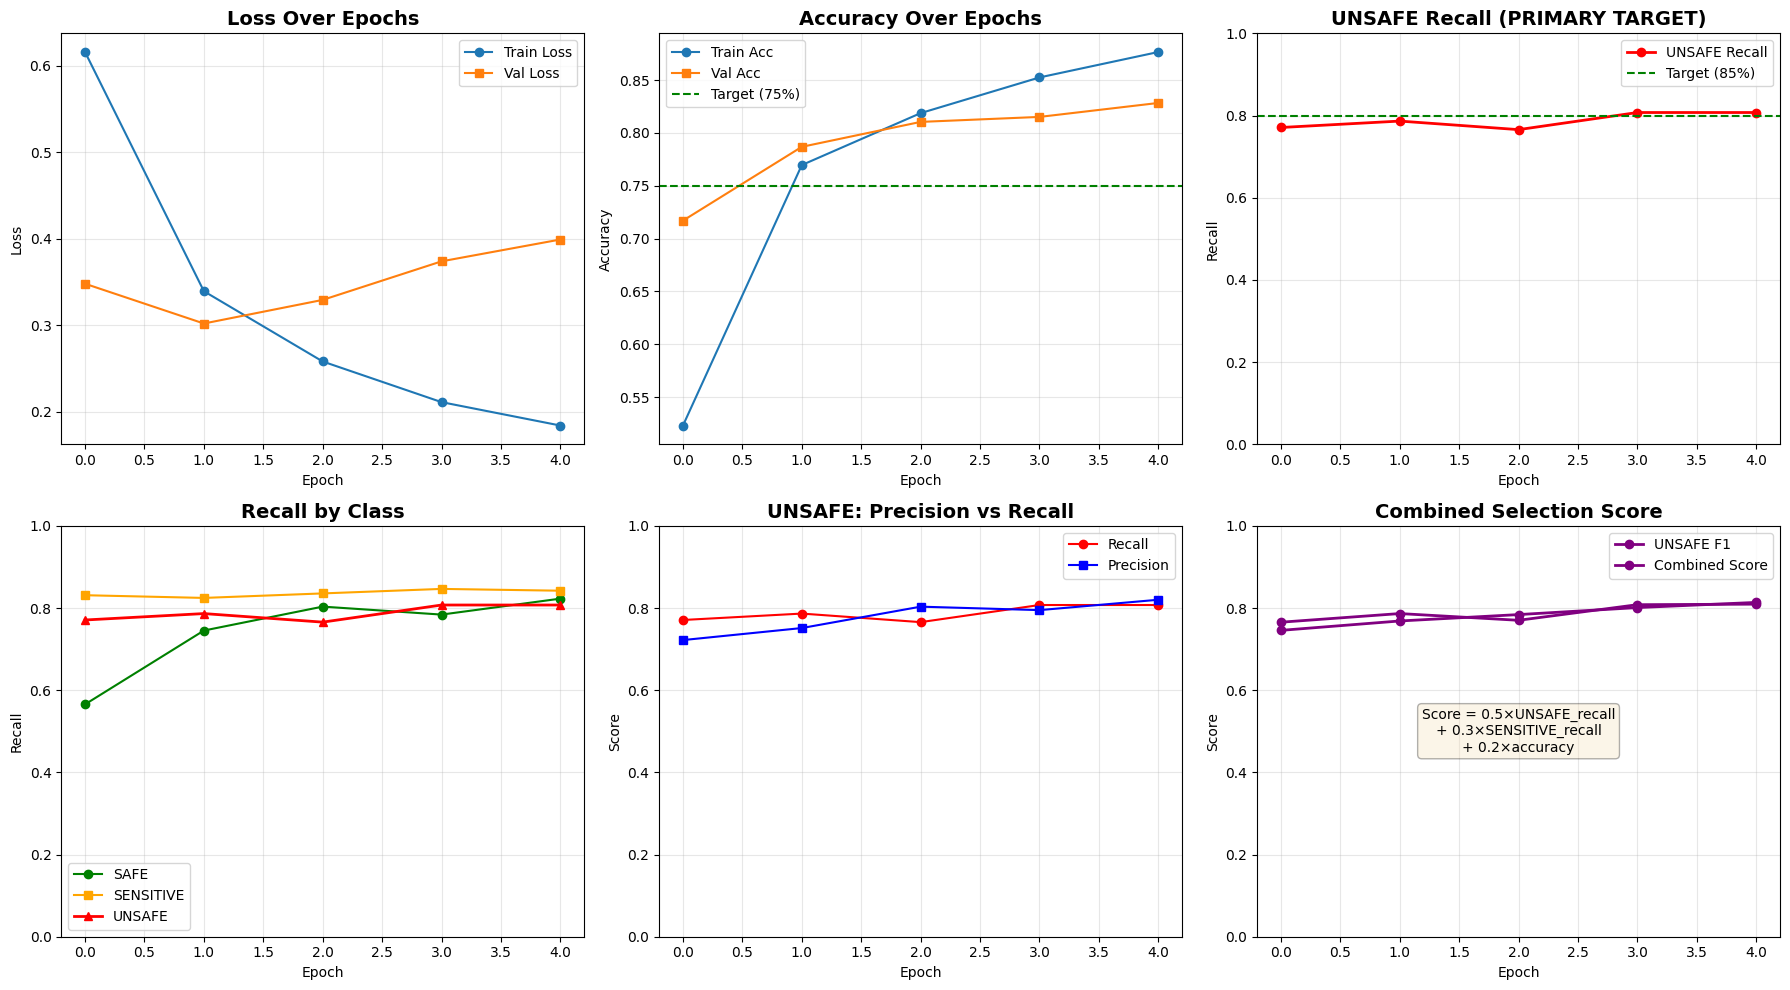


✓ Training history saved


In [21]:
print("\n" + "="*80)
print("PLOTTING TRAINING HISTORY")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].axhline(y=0.75, color='green', linestyle='--', label='Target (75%)')
axes[0, 1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# UNSAFE Recall (PRIMARY METRIC)
axes[0, 2].plot(history['val_unsafe_recall'], label='UNSAFE Recall', marker='o', color='red', linewidth=2)
axes[0, 2].axhline(y=0.80, color='green', linestyle='--', label='Target (85%)')
axes[0, 2].set_title('UNSAFE Recall (PRIMARY TARGET)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim([0, 1])

# Per-Class Recall
axes[1, 0].plot(history['val_safe_recall'], label='SAFE', marker='o', color='green')
axes[1, 0].plot(history['val_sensitive_recall'], label='SENSITIVE', marker='s', color='orange')
axes[1, 0].plot(history['val_unsafe_recall'], label='UNSAFE', marker='^', color='red', linewidth=2)
axes[1, 0].set_title('Recall by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# UNSAFE Precision vs Recall
axes[1, 1].plot(history['val_unsafe_recall'], label='Recall', marker='o', color='red')
axes[1, 1].plot(history['val_unsafe_precision'], label='Precision', marker='s', color='blue')
axes[1, 1].set_title('UNSAFE: Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

# UNSAFE F1
axes[1, 2].plot(history['val_unsafe_f1'], label='UNSAFE F1', marker='o', color='purple', linewidth=2)
axes[1, 2].set_title('UNSAFE F1 Score', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim([0, 1])

# combined score
axes[1, 2].plot(history['combined_score'], label='Combined Score', marker='o', color='purple', linewidth=2)
axes[1, 2].set_title('Combined Selection Score', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Score')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim([0, 1])
axes[1, 2].text(0.5, 0.5, 
                'Score = 0.5×UNSAFE_recall\n+ 0.3×SENSITIVE_recall\n+ 0.2×accuracy',
                transform=axes[1, 2].transAxes,
                fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'multiclass_classifier', 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training history saved")

## 14. Load Best Model and Evaluate

In [22]:
print("\n" + "="*80)
print("LOADING BEST MODEL FOR EVALUATION")
print("="*80)

best_model = RobertaForSequenceClassification.from_pretrained(
    os.path.join(PROJECT_ROOT, 'models', 'multiclass_classifier', 'best_model')
)
best_model = best_model.to(device)

print("✓ Best model loaded")

# Evaluate on validation set
val_loss, val_acc, val_metrics, val_preds, val_labels, val_probs = evaluate(
    best_model, val_loader, device, focal_loss_fn
)

print("\n" + "="*80)
print("VALIDATION SET RESULTS (Best Model)")
print("="*80)
print(f"Overall Accuracy: {val_acc:.4f} ({'✓' if val_acc >= 0.75 else '✗'} target: ≥0.75)")
print(f"Loss: {val_loss:.4f}")

print(f"\n{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
print("-" * 60)
for class_name in ['SAFE', 'SENSITIVE', 'UNSAFE']:
    metrics = val_metrics[class_name]
    print(f"{class_name:<12} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['support']:<10}")

print("\n" + "="*80)
print("UNSAFE CLASS (PRIMARY TARGET)")
print("="*80)
print(f"Recall: {val_metrics['UNSAFE']['recall']:.4f} ({'✓ PASS' if val_metrics['UNSAFE']['recall'] >= 0.80 else '✗ FAIL'} target: ≥0.80)")
print(f"Precision: {val_metrics['UNSAFE']['precision']:.4f}")
print(f"F1: {val_metrics['UNSAFE']['f1']:.4f}")


LOADING BEST MODEL FOR EVALUATION
✓ Best model loaded


Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]


VALIDATION SET RESULTS (Best Model)
Overall Accuracy: 0.8283 (✓ target: ≥0.75)
Loss: 0.3990

Class        Precision    Recall       F1           Support   
------------------------------------------------------------
SAFE         0.8874       0.8228       0.8539       412       
SENSITIVE    0.7853       0.8421       0.8127       456       
UNSAFE       0.8201       0.8073       0.8136       192       

UNSAFE CLASS (PRIMARY TARGET)
Recall: 0.8073 (✓ PASS target: ≥0.80)
Precision: 0.8201
F1: 0.8136


## 15. Confusion Matrix

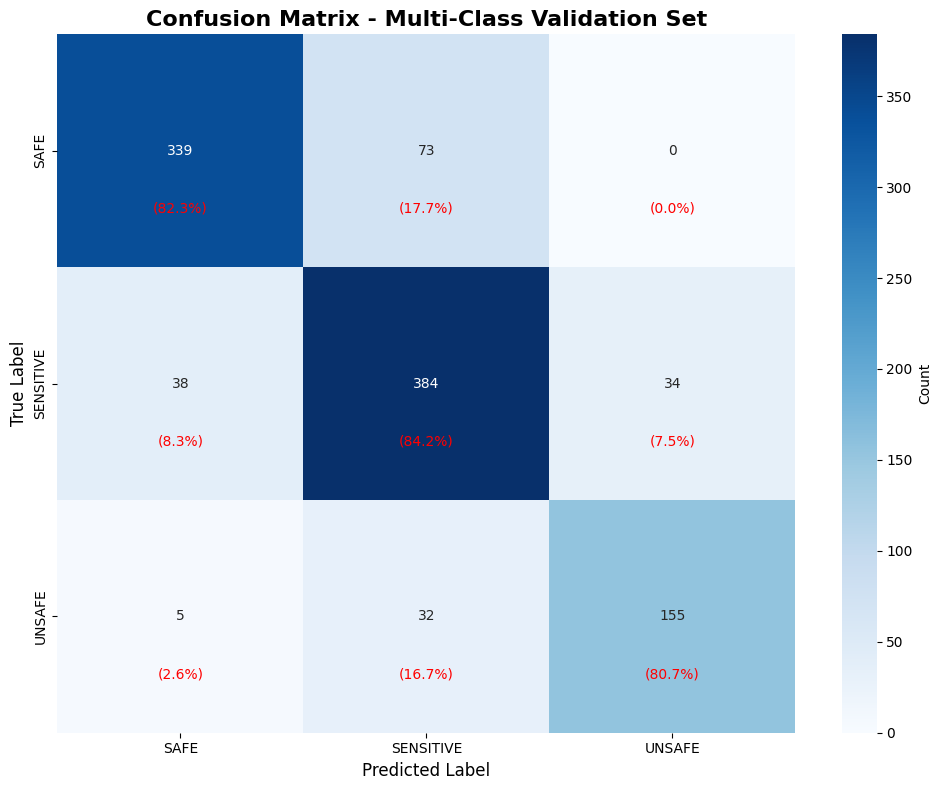


UNSAFE MISCLASSIFICATION ANALYSIS
Total UNSAFE samples: 192
Correctly classified: 155 (80.7%)
Misclassified as SAFE: 5 (2.6%) ⚠️⚠️⚠️
Misclassified as SENSITIVE: 32 (16.7%) ⚠️

✓ Confusion matrix saved


In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['SAFE', 'SENSITIVE', 'UNSAFE'],
    yticklabels=['SAFE', 'SENSITIVE', 'UNSAFE'],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Multi-Class Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
for i in range(3):
    for j in range(3):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.75, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'results', 'multiclass_classifier', 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Analyze UNSAFE misclassifications
unsafe_idx = label2id['UNSAFE']
unsafe_total = cm[unsafe_idx].sum()
unsafe_correct = cm[unsafe_idx, unsafe_idx]
unsafe_as_safe = cm[unsafe_idx, label2id['SAFE']]
unsafe_as_sensitive = cm[unsafe_idx, label2id['SENSITIVE']]

print(f"\n{'='*80}")
print("UNSAFE MISCLASSIFICATION ANALYSIS")
print(f"{'='*80}")
print(f"Total UNSAFE samples: {unsafe_total}")
print(f"Correctly classified: {unsafe_correct} ({unsafe_correct/unsafe_total*100:.1f}%)")
print(f"Misclassified as SAFE: {unsafe_as_safe} ({unsafe_as_safe/unsafe_total*100:.1f}%) ⚠️⚠️⚠️")
print(f"Misclassified as SENSITIVE: {unsafe_as_sensitive} ({unsafe_as_sensitive/unsafe_total*100:.1f}%) ⚠️")

print("\n✓ Confusion matrix saved")

## 16. Save Predictions

In [24]:
val_predictions = pd.DataFrame({
    'text': val_df['text'].values,
    'true_label': [id2label[label] for label in val_labels],
    'predicted_label': [id2label[pred] for pred in val_preds],
    'safe_prob': [probs[0] for probs in val_probs],
    'sensitive_prob': [probs[1] for probs in val_probs],
    'unsafe_prob': [probs[2] for probs in val_probs],
    'correct': np.array(val_labels) == np.array(val_preds)
})

val_predictions.to_csv(os.path.join(PROJECT_ROOT, 'results', 'multiclass_classifier', 'validation_predictions.csv'), index=False)

print("\n✓ Validation predictions saved")
print(f"  Total predictions: {len(val_predictions)}")
print(f"  Correct: {val_predictions['correct'].sum()} ({val_predictions['correct'].mean()*100:.1f}%)")

# Analyze false negatives (UNSAFE predicted as SAFE/SENSITIVE)
false_negatives = val_predictions[
    (val_predictions['true_label'] == 'UNSAFE') & 
    (val_predictions['predicted_label'] != 'UNSAFE')
]

print(f"\n⚠️ CRITICAL: False Negatives (Missed UNSAFE): {len(false_negatives)}")
if len(false_negatives) > 0:
    print(f"\nTop 3 missed UNSAFE articles:")
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\n  Predicted as: {row['predicted_label']}")
        print(f"  UNSAFE probability: {row['unsafe_prob']:.3f}")
        print(f"  Text: {row['text'][:200]}...")
        print("-" * 80)


✓ Validation predictions saved
  Total predictions: 1060
  Correct: 878 (82.8%)

⚠️ CRITICAL: False Negatives (Missed UNSAFE): 37

Top 3 missed UNSAFE articles:

  Predicted as: SENSITIVE
  UNSAFE probability: 0.115
  Text: Leos Janáček's Jenůfa premiered in Brno in 1904 and returned to the Metropolitan Opera on Friday for the first time in ten years. The bleak opera is a fascinating and elegantly-proportioned psychologi...
--------------------------------------------------------------------------------

  Predicted as: SENSITIVE
  UNSAFE probability: 0.192
  Text: DraftKings (NASDAQ:DKNG–Free Report) had its price objective decreased by Susquehanna from $40.00 to $37.00 in a report published on Friday morning. The firm currently has a positive rating on the sto...
--------------------------------------------------------------------------------

  Predicted as: SENSITIVE
  UNSAFE probability: 0.285
  Text: Revenues Increase to $3.3 million and $9.9 million from $1.3 Million and $4.9 M

## 17. Summary

In [25]:
print("\n" + "="*80)
print("MULTI-CLASS TRAINING COMPLETE!")
print("="*80)

print("\nFinal Results:")
print(f"  Overall Accuracy: {val_acc:.4f} (target: ≥0.75)")
print(f"\n  SAFE:")
print(f"    Recall: {val_metrics['SAFE']['recall']:.4f}")
print(f"    Precision: {val_metrics['SAFE']['precision']:.4f}")
print(f"    F1: {val_metrics['SAFE']['f1']:.4f}")
print(f"\n  SENSITIVE:")
print(f"    Recall: {val_metrics['SENSITIVE']['recall']:.4f}")
print(f"    Precision: {val_metrics['SENSITIVE']['precision']:.4f}")
print(f"    F1: {val_metrics['SENSITIVE']['f1']:.4f}")
print(f"\n  UNSAFE (PRIMARY):")
print(f"    Recall: {val_metrics['UNSAFE']['recall']:.4f} (target: ≥0.85)")
print(f"    Precision: {val_metrics['UNSAFE']['precision']:.4f}")
print(f"    F1: {val_metrics['UNSAFE']['f1']:.4f}")

print("\nSaved artifacts:")
print("  models/multiclass_classifier/best_model/")
print("  results/multiclass_classifier/training_history.png")
print("  results/multiclass_classifier/confusion_matrix.png")
print("  results/multiclass_classifier/validation_predictions.csv")

# Verdict
if val_metrics['UNSAFE']['recall'] >= 0.80 and val_acc >= 0.75:
    print("\n✓✓✓ SUCCESS: Model meets targets!")
elif val_metrics['UNSAFE']['recall'] >= 0.80:
    print("\n✓ PARTIAL SUCCESS: UNSAFE recall good, but overall accuracy low")
elif val_acc >= 0.75:
    print("\n⚠️ PARTIAL SUCCESS: Overall accuracy good, but UNSAFE recall low")
else:
    print("\n✗ NEEDS IMPROVEMENT: Both metrics below target")

print("\n" + "="*80)


MULTI-CLASS TRAINING COMPLETE!

Final Results:
  Overall Accuracy: 0.8283 (target: ≥0.75)

  SAFE:
    Recall: 0.8228
    Precision: 0.8874
    F1: 0.8539

  SENSITIVE:
    Recall: 0.8421
    Precision: 0.7853
    F1: 0.8127

  UNSAFE (PRIMARY):
    Recall: 0.8073 (target: ≥0.85)
    Precision: 0.8201
    F1: 0.8136

Saved artifacts:
  models/multiclass_classifier/best_model/
  results/multiclass_classifier/training_history.png
  results/multiclass_classifier/confusion_matrix.png
  results/multiclass_classifier/validation_predictions.csv

✓✓✓ SUCCESS: Model meets targets!

